# Progetto di statistica

## Carico tutto ciò che c'è da caricare.

Librerie e dati

In [1]:
import pandas as pd
import scipy
from scipy.stats import chi2

from pygam import LogisticGAM, s, l

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, confusion_matrix, recall_score, f1_score, precision_recall_curve, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

from multiprocessing import Process
import multiprocessing

import plotly.express as px
import graphviz

from pdpbox import pdp, info_plots

import os
import sys

# Set the number of CPU cores to use
num_cores = multiprocessing.cpu_count()
print("Number of CPU cores:", num_cores)

# Define the current working directory
cwd = os.getcwd()

# load the data
data = pd.read_csv(cwd + '/health_data.csv')
data

Number of CPU cores: 16


,Unnamed: 0,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,0.0,18393.0,1,168.0,62.0,110.0,80.0,0,0,0,0,1,0
1,1,1.0,20228.0,0,156.0,85.0,140.0,90.0,2,0,0,0,1,1
2,2,2.0,18857.0,0,165.0,64.0,130.0,70.0,2,0,0,0,0,1
3,3,3.0,17623.0,1,169.0,82.0,150.0,100.0,0,0,0,0,1,1
4,4,4.0,17474.0,0,156.0,56.0,100.0,60.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,69995,99993.0,19240.0,1,168.0,76.0,120.0,80.0,0,0,1,0,1,0
69996,69996,99995.0,22601.0,0,158.0,126.0,140.0,90.0,1,1,0,0,1,1
69997,69997,99996.0,19066.0,1,183.0,105.0,180.0,90.0,2,0,0,1,0,1
69998,69998,99998.0,22431.0,0,163.0,72.0,135.0,80.0,0,1,0,0,0,1


## Prime operazioni di pulizia

Trasforma categoriche in `str`, butta via `NaN` (spoiler: non ce ne sono), butta via le colonne inutili, converti l'età in anni, elimina i valori assurdi, aggiungi la colonna del `BMI` just in case, sposta la colonna `cardio` in fondo.

In [2]:
# Create a working copy to avoid modifying the original data
df = data.copy()

# Define th list of categoriacl variables
categorical = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

# Convert inf to NaN, although according to the data description there are no Infs
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove NaNs, although according to the data description there are no NaNs
df.dropna(inplace=True)

# Drop the id column and -1
df.drop(['id', 'Unnamed: 0'], axis=1, inplace=True)

# Convert age in days
df['age'] = df['age']/365.25

# Filter for impossible values for height, weight, ap_hi, ap_lo
df = df[(df['height'] > 130) & (df['height'] < 220)]
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['ap_hi'] > 60) & (df['ap_hi'] < 240)]
df = df[(df['ap_lo'] > 40) & (df['ap_lo'] < 200)]
df = df[df['age'] <100]

# Add a new column for the BMI
df['BMI'] = df['weight'] / (df['height'] / 100) ** 2

# Filter for reasonable values for BMI
df = df[(df['BMI'] > 6) & (df['BMI'] < 70)]

# Convert all categorical variables to strings,
# this will be undone at a later stage (remember to do it before the model)
df[categorical] = df[categorical].astype(str)

# Reset index for... resons?
df.reset_index(drop=True, inplace=True)

# Put the cardio column at the end
df = df[[c for c in df if c not in ['cardio']] + ['cardio']]

# Here's the resulting df
df


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,cardio
0,50.357290,1,168.0,62.0,110.0,80.0,0,0,0,0,1,21.967120,0
1,55.381246,0,156.0,85.0,140.0,90.0,2,0,0,0,1,34.927679,1
2,51.627652,0,165.0,64.0,130.0,70.0,2,0,0,0,0,23.507805,1
3,48.249144,1,169.0,82.0,150.0,100.0,0,0,0,0,1,28.710479,1
4,47.841205,0,156.0,56.0,100.0,60.0,0,0,0,0,0,23.011177,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68636,52.676249,1,168.0,76.0,120.0,80.0,0,0,1,0,1,26.927438,0
68637,61.878166,0,158.0,126.0,140.0,90.0,1,1,0,0,1,50.472681,1
68638,52.199863,1,183.0,105.0,180.0,90.0,2,0,0,1,0,31.353579,1
68639,61.412731,0,163.0,72.0,135.0,80.0,0,1,0,0,0,27.099251,1


## Rapida analisi del dataset

Proprietà del datset

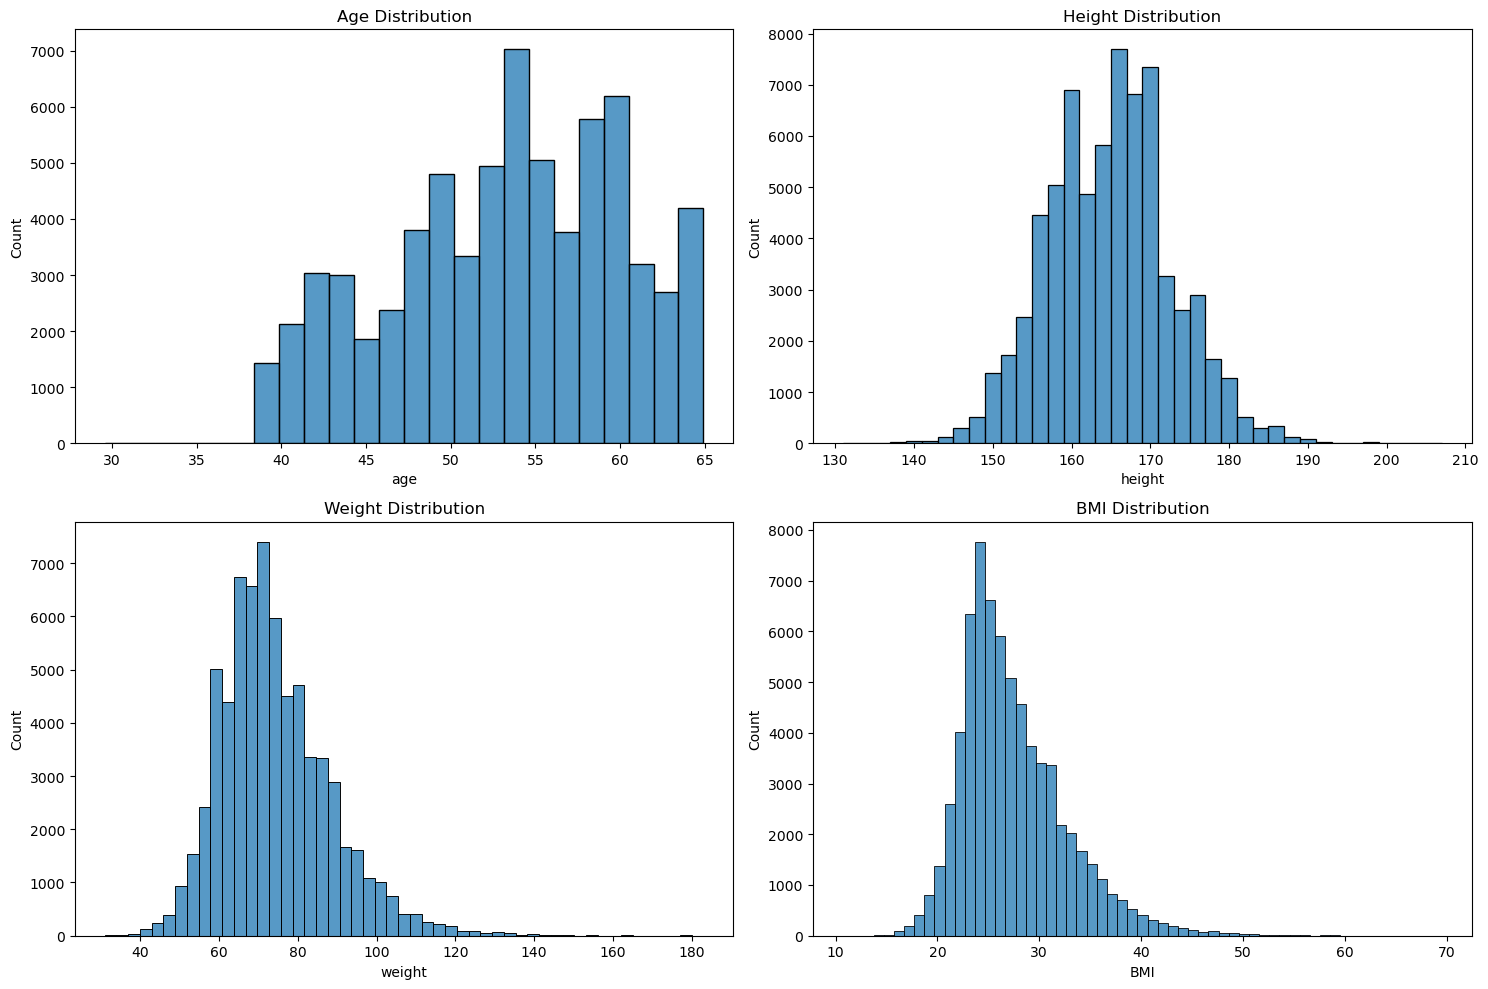

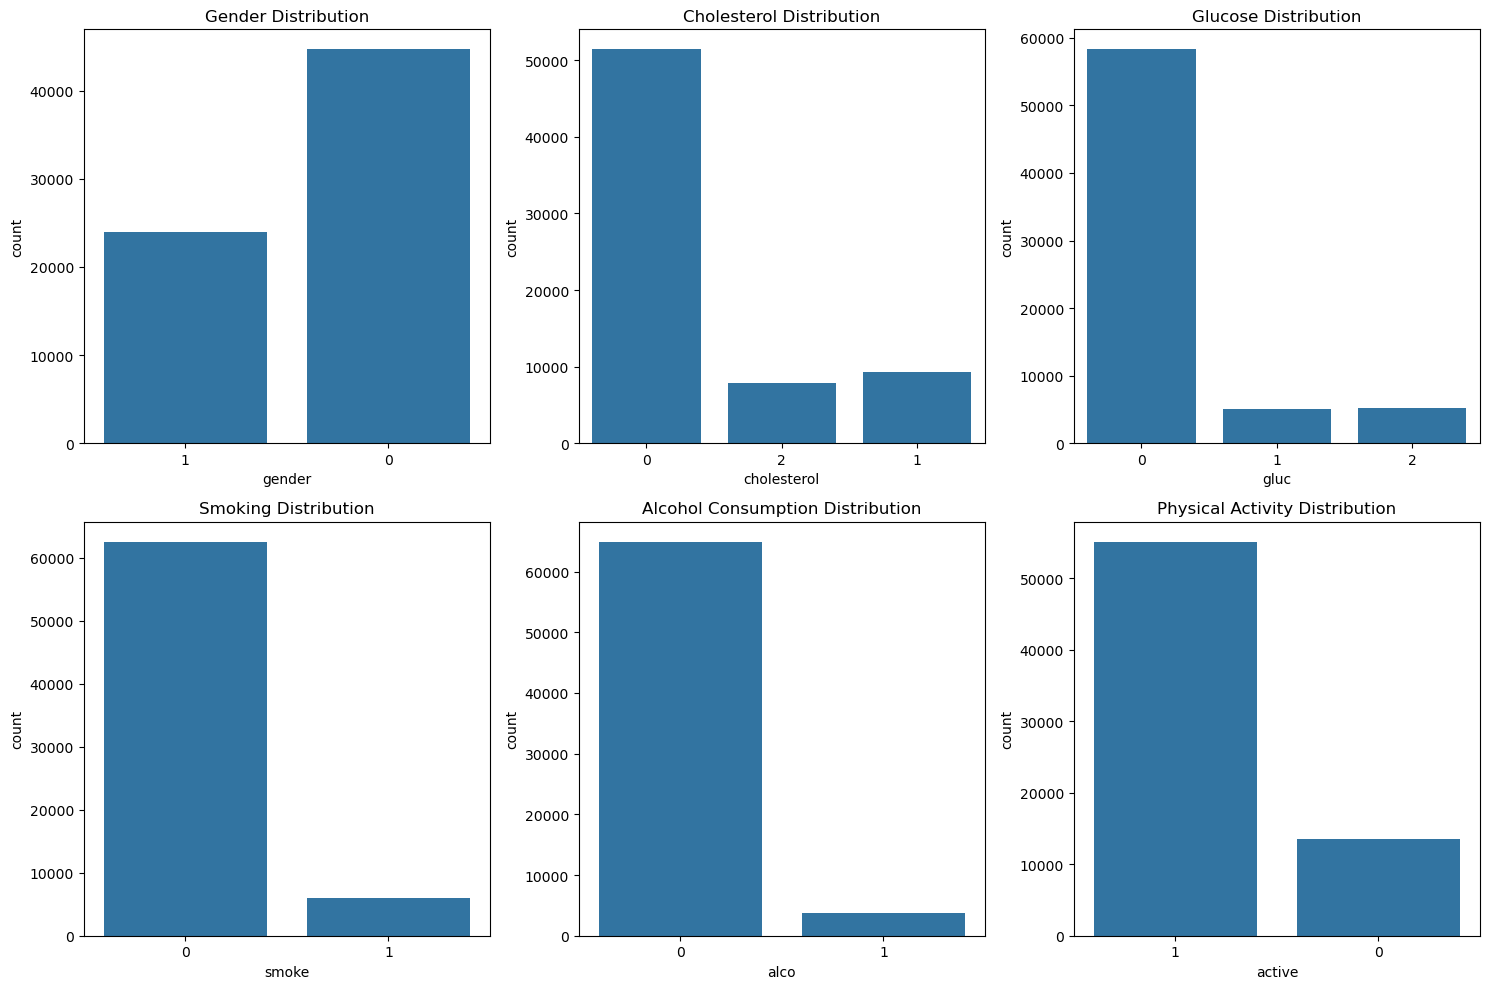

In [3]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

#########################
## Numerical Variables ##
#########################

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution')
sns.histplot(df_eda, x='height', binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution')
sns.histplot(df_eda, x='weight', binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution')
sns.histplot(df_eda, x='BMI', binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution')
plt.tight_layout()
plt.show()

###########################
## Categorical Variables ##
###########################

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution')
sns.countplot(x='cholesterol', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution')
sns.countplot(x='gluc', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution')
sns.countplot(x='smoke', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution')
sns.countplot(x='alco', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution')
sns.countplot(x='active', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution')
plt.tight_layout()
plt.show()



## EDA

Explore data relationships

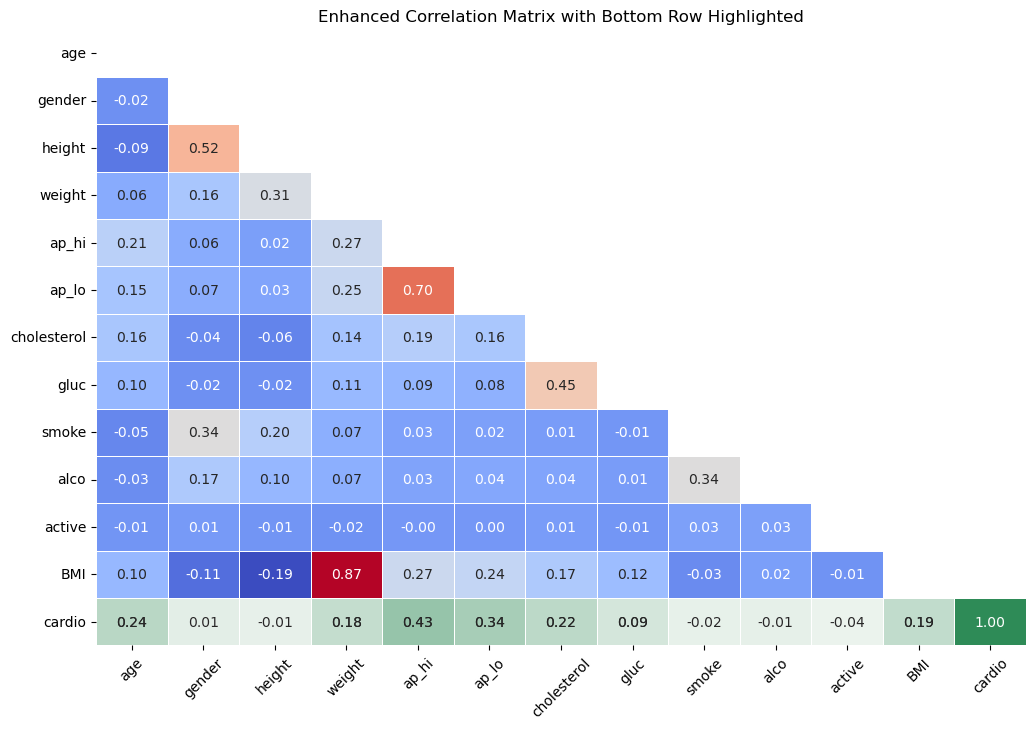

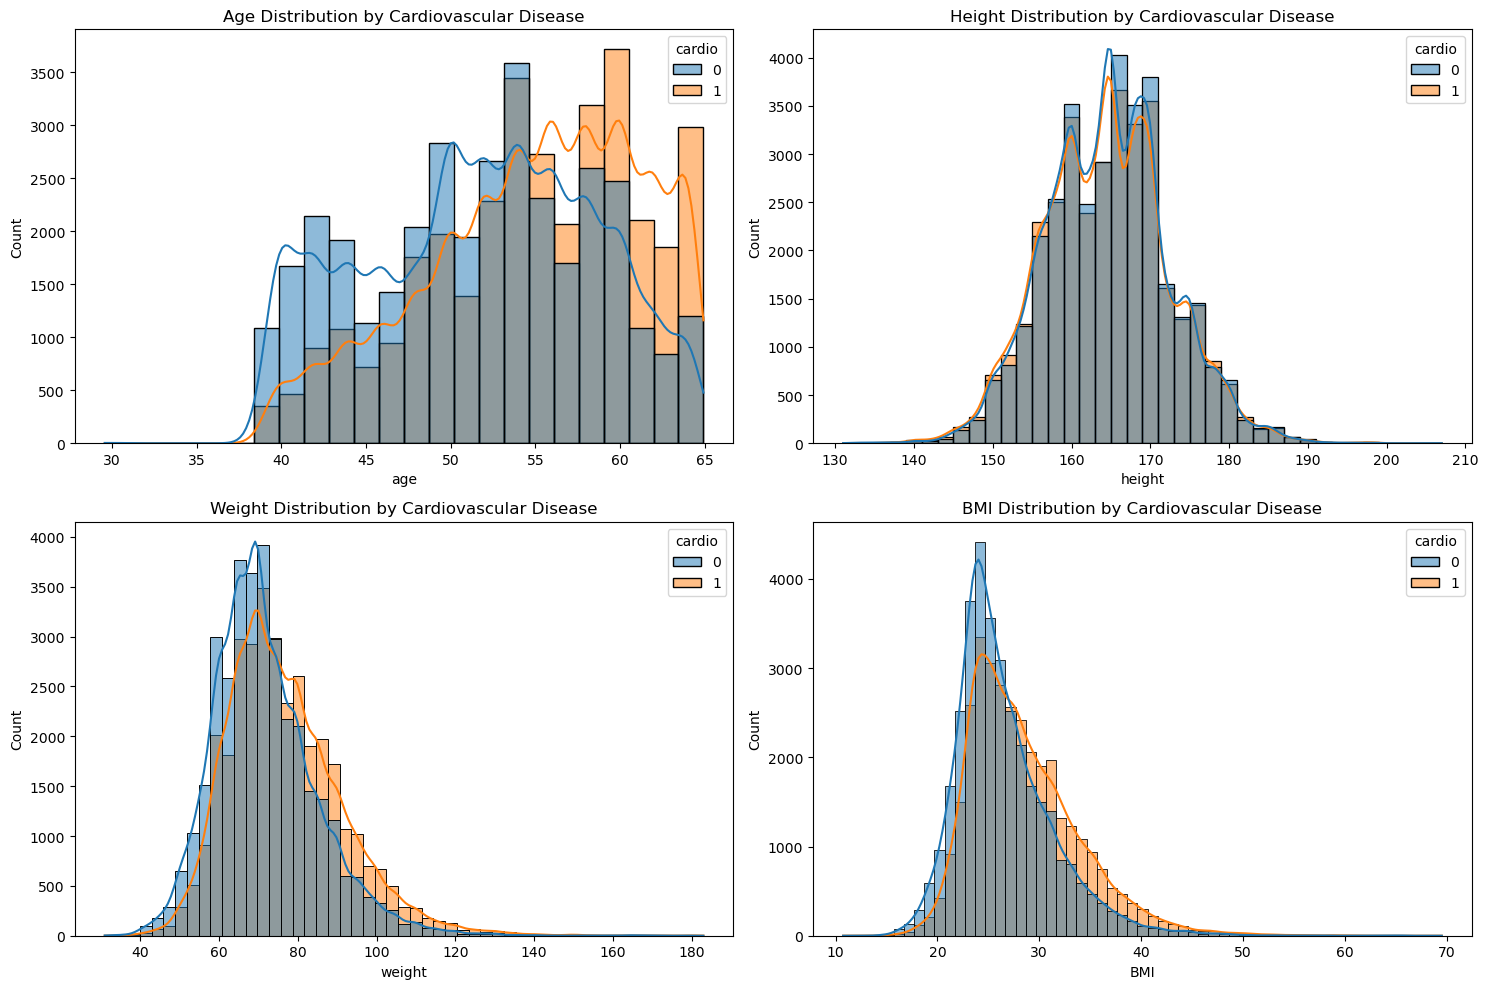

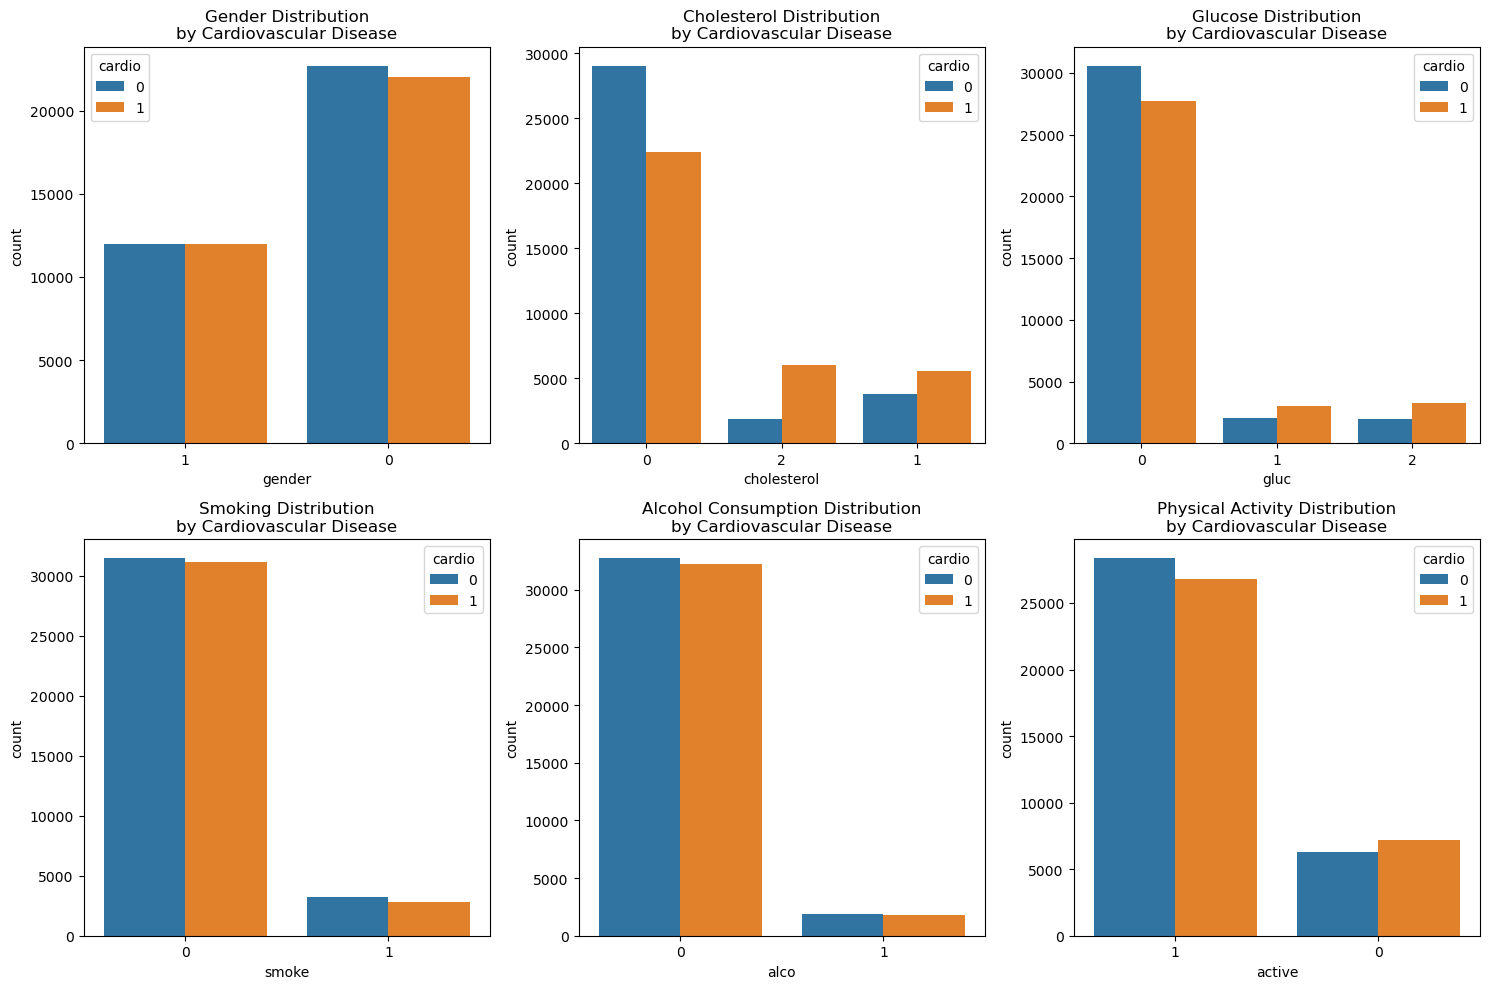

In [4]:
# Create a copy of the cleaned dataset to use for EDA
df_eda = df.copy()

####################################################
## CORRELATION MATRIX WITH HIGHLIGHTED BOTTOM ROW ##
####################################################

plt.figure(figsize=(12, 8))
# Creating a mask for the upper triangle
mask_upper = np.triu(np.ones_like(df.corr(), dtype=bool))
# Creating a mask for all but the bottom row (for highlighting)
mask_not_bottom = np.ones_like(df.corr(), dtype=bool)
mask_not_bottom[-1, :] = False  # Unmask the bottom row
# Plot the main heatmap with the upper triangle masked
sns.heatmap(df.corr(), annot=True, mask=mask_upper, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=False)
# Overlay with the bottom row highlighted
# Adjust 'highlight_cmap' to change the highlight color
highlight_cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, mask=mask_not_bottom, cmap=highlight_cmap, fmt=".2f", linewidths=.5, cbar=False)
plt.xticks(rotation=45)
plt.title('Enhanced Correlation Matrix with Bottom Row Highlighted')
plt.show()

#######################################################
## DISTRIBUTION OF DATA ACCORDING TO TARGET VARIABLE ##
#######################################################

## Numerical ##

fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df_eda, x='age', hue='cardio', kde=True, binwidth=1.5, ax=ax[0, 0])
ax[0, 0].set_title('Age Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='height', hue='cardio', kde=True, binwidth=2, ax=ax[0, 1])
ax[0, 1].set_title('Height Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='weight', hue='cardio', kde=True, binwidth=3, ax=ax[1, 0])
ax[1, 0].set_title('Weight Distribution by Cardiovascular Disease')
sns.histplot(df_eda, x='BMI', hue='cardio', kde=True, binwidth=1, ax=ax[1, 1])
ax[1, 1].set_title('BMI Distribution by Cardiovascular Disease')
plt.tight_layout()
plt.show()

## Categorical ##

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='gender', hue='cardio', data=df_eda,ax=ax[0, 0])
ax[0, 0].set_title('Gender Distribution\nby Cardiovascular Disease')
sns.countplot(x='cholesterol', hue='cardio', data=df_eda, ax=ax[0, 1])
ax[0, 1].set_title('Cholesterol Distribution\nby Cardiovascular Disease')
sns.countplot(x='gluc', hue='cardio', data=df_eda, ax=ax[0, 2])
ax[0, 2].set_title('Glucose Distribution\nby Cardiovascular Disease')
sns.countplot(x='smoke', hue='cardio', data=df_eda, ax=ax[1, 0])
ax[1, 0].set_title('Smoking Distribution\nby Cardiovascular Disease')
sns.countplot(x='alco', hue='cardio', data=df_eda, ax=ax[1, 1])
ax[1, 1].set_title('Alcohol Consumption Distribution\nby Cardiovascular Disease')
sns.countplot(x='active', hue='cardio', data=df_eda, ax=ax[1, 2])
ax[1, 2].set_title('Physical Activity Distribution\nby Cardiovascular Disease')
plt.tight_layout()
plt.show()


## Class balance

In [5]:
# Create a copy of the cleaned dataset to use for logistic regression with balanced data
df_regression_balanced = df.copy()

# Convert all categorical variables to integers
df_regression_balanced[categorical] = df_regression_balanced[categorical].astype(int)

# Drop the "bad columns" ['gluc', 'alco', 'height', 'ap_lo', 'gender']
df_regression_balanced.drop(columns = ['gluc', 'alco', 'height', 'ap_lo', 'gender'], inplace=True)

# Find the number of samples in each class and for each categorical variable
print(df_regression_balanced['cardio'].value_counts())
print(df_regression_balanced['cholesterol'].value_counts())
print(df_regression_balanced['smoke'].value_counts())
print(df_regression_balanced['active'].value_counts())

# The above code returns the following:
# cardio
# 0    34673
# 1    33968
# Name: count, dtype: int64
# cholesterol
# 0    51469
# 1     9297
# 2     7875
# Name: count, dtype: int64
# smoke
# 0    62598
# 1     6043
# Name: count, dtype: int64
# active
# 1    55150
# 0    13491
# Name: count, dtype: int64

#Actually, the classes are balanced, so we don't need to do anything

cardio
0    34673
1    33968
Name: count, dtype: int64
cholesterol
0    51469
1     9297
2     7875
Name: count, dtype: int64
smoke
0    62598
1     6043
Name: count, dtype: int64
active
1    55150
0    13491
Name: count, dtype: int64


## LOGISTIC REGRESSION CON IL LINEAR MODEL

Logistic regression, con full model, null model, senza le variabili di cui sopra, togliendo le variabili con P Value alto. Quello dopo sarà con le cose bilanciate.

In [6]:
# Create a copy of the cleaned dataset to use for logistic regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

################
## FULL MODEL ##
################

# Create a copy for the full model
df_full = df_regression.copy()

# Create a dummied version
df_full = pd.get_dummies(df_full, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_full['intercept'] = 1.0

# Fit the logistic regression model
full_model = sm.Logit(df_full['cardio'], df_full.drop(columns=['cardio'])).fit()

# Display the model's summary
print(full_model.summary())

################
## NULL MODEL ##
################

# Fit the null model
null_model = sm.Logit(df_full['cardio'], df_full['intercept']).fit()
print(null_model.summary())

##################
## NESTED MODEL ##
##################

# Create a copy for the nested model
nested_model = df_regression.copy()

# Drop the unwanted columns, except age
nested_model.drop(columns = ['gluc', 'alco', 'height', 'ap_lo'], inplace=True)

# Create a dummied version
nested_model = pd.get_dummies(nested_model, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model['intercept'] = 1.0

# Fit the logistic regression model
nested_model = sm.Logit(nested_model['cardio'], nested_model.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model.summary())

#################################
## NESTED MODEL WITHOUT GENDER ##
#################################

# Create a copy for the nested model without gender

nested_model_no_gender = df_regression.copy()

# Drop the unwanted columns
nested_model_no_gender.drop(columns = ['gluc', 'alco', 'height', 'ap_lo', 'gender'], inplace=True)

# Create a dummied version
nested_model_no_gender = pd.get_dummies(nested_model_no_gender, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model_no_gender['intercept'] = 1.0

# Fit the logistic regression model
nested_model_no_gender = sm.Logit(nested_model_no_gender['cardio'], nested_model_no_gender.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model_no_gender.summary())

##############################
## ALTERNATIVE NESTED MODEL ##
##############################

# Create a copy for the alternative nested model
nested_model_alt = df_regression.copy()

# Drop the unwanted columns
nested_model_alt.drop(columns = ['gender', 'height', 'BMI'], inplace=True)

# Create a dummied version
nested_model_alt = pd.get_dummies(nested_model_alt, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
nested_model_alt['intercept'] = 1.0

# Fit the logistic regression model
nested_model_alt = sm.Logit(nested_model_alt['cardio'], nested_model_alt.drop(columns=['cardio'])).fit()

# Display the model's summary
print(nested_model_alt.summary())

########################
## COMPARE THE MODELS ##
########################

# Create a function to perform the likelihood ratio test
def likelihood_ratio_test(full_model, nested_model):
    LR_statistic = -2*(nested_model.llf - full_model.llf)
    df = len(full_model.params) - len(nested_model.params)
    p_val = scipy.stats.chi2.sf(LR_statistic, df)
    return LR_statistic, p_val

# Perform the likelihood ratio test
print("FULL MODEL VS NULL MODEL")
LR_statistic, p_val = likelihood_ratio_test(full_model, null_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("NESTED MODEL VS FULL MODEL")
LR_statistic, p_val = likelihood_ratio_test(full_model, nested_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("NESTED MODEL WITHOUT GENDER VS NESTED MODEL")
LR_statistic, p_val = likelihood_ratio_test(nested_model, nested_model_no_gender)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

print("ALTERNATIVE NESTED MODEL VS NESTED MODEL")
LR_statistic, p_val = likelihood_ratio_test(nested_model_alt, nested_model)
print('Likelihood Ratio statistic: ', LR_statistic)
print('p-value: ', p_val)

Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        12:13:39   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

## GAM

Optimization terminated successfully.
         Current function value: 0.560952
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 cardio   No. Observations:                68641
Model:                          Logit   Df Residuals:                    68628
Method:                           MLE   Df Model:                           12
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.1907
Time:                        12:28:20   Log-Likelihood:                -38504.
converged:                       True   LL-Null:                       -47575.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
age             0.0516      0.001     38.033      0.000       0.049       0.054
gender         -0.0149    

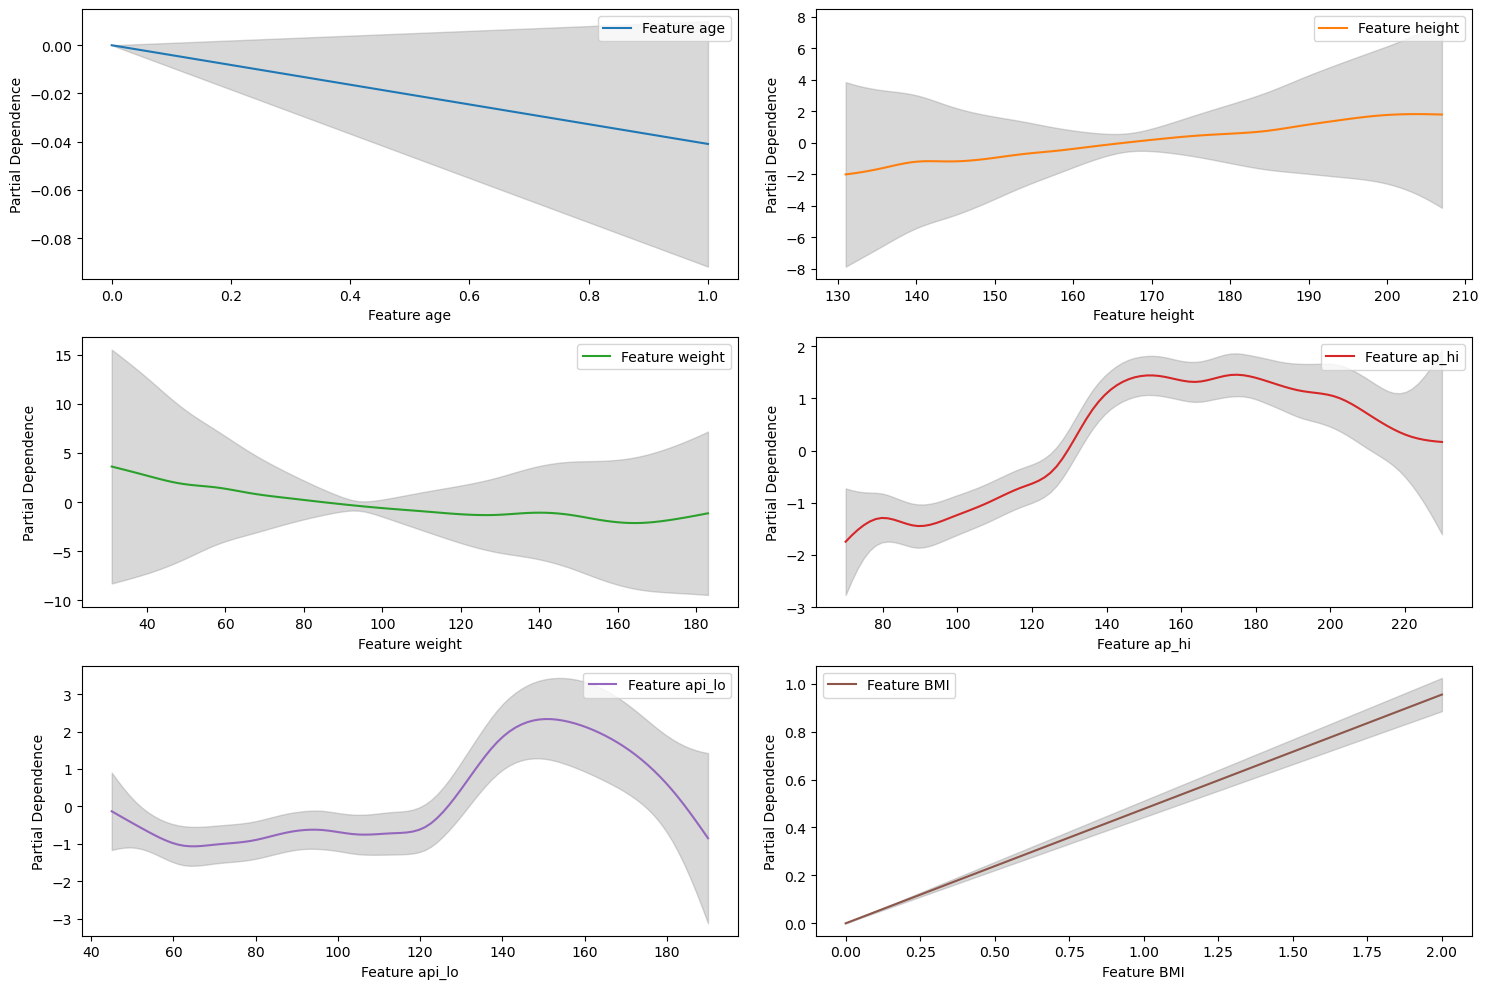

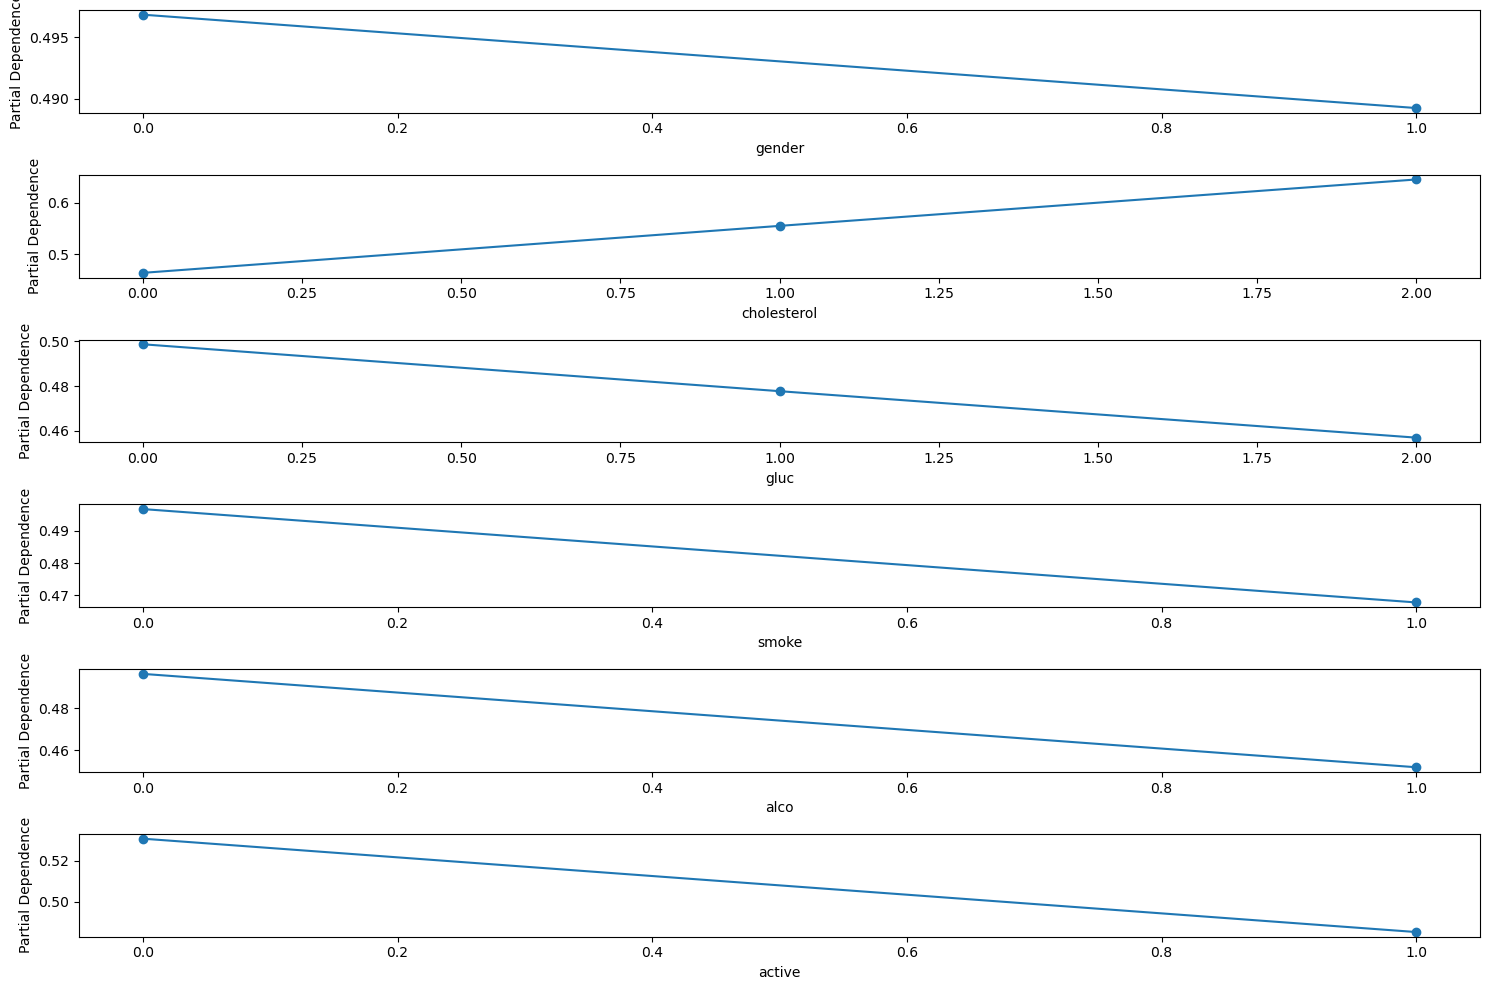

AUC Score: 0.7950609070276244
Accuracy: 0.7278885797118341
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     44.2167
Link Function:                        LogitLink Log Likelihood:                                -37911.0886
Number of Samples:                        68641 AIC:                                            75910.6106
                                                AICc:                                           75910.6715
                                                UBRE:                                               3.1064
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                    

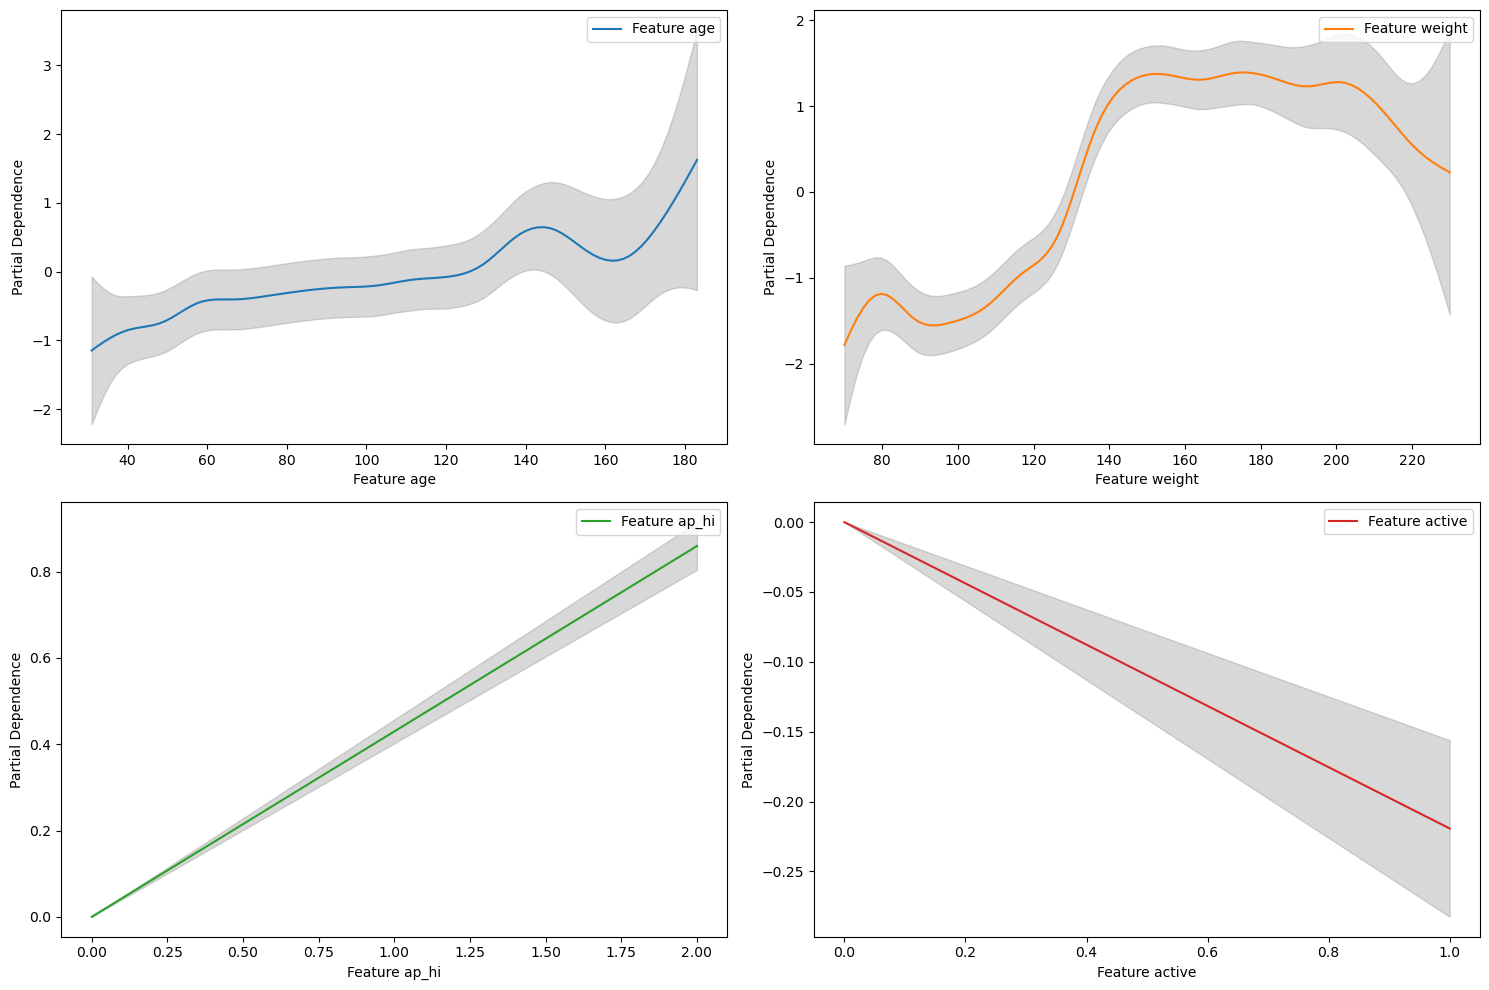

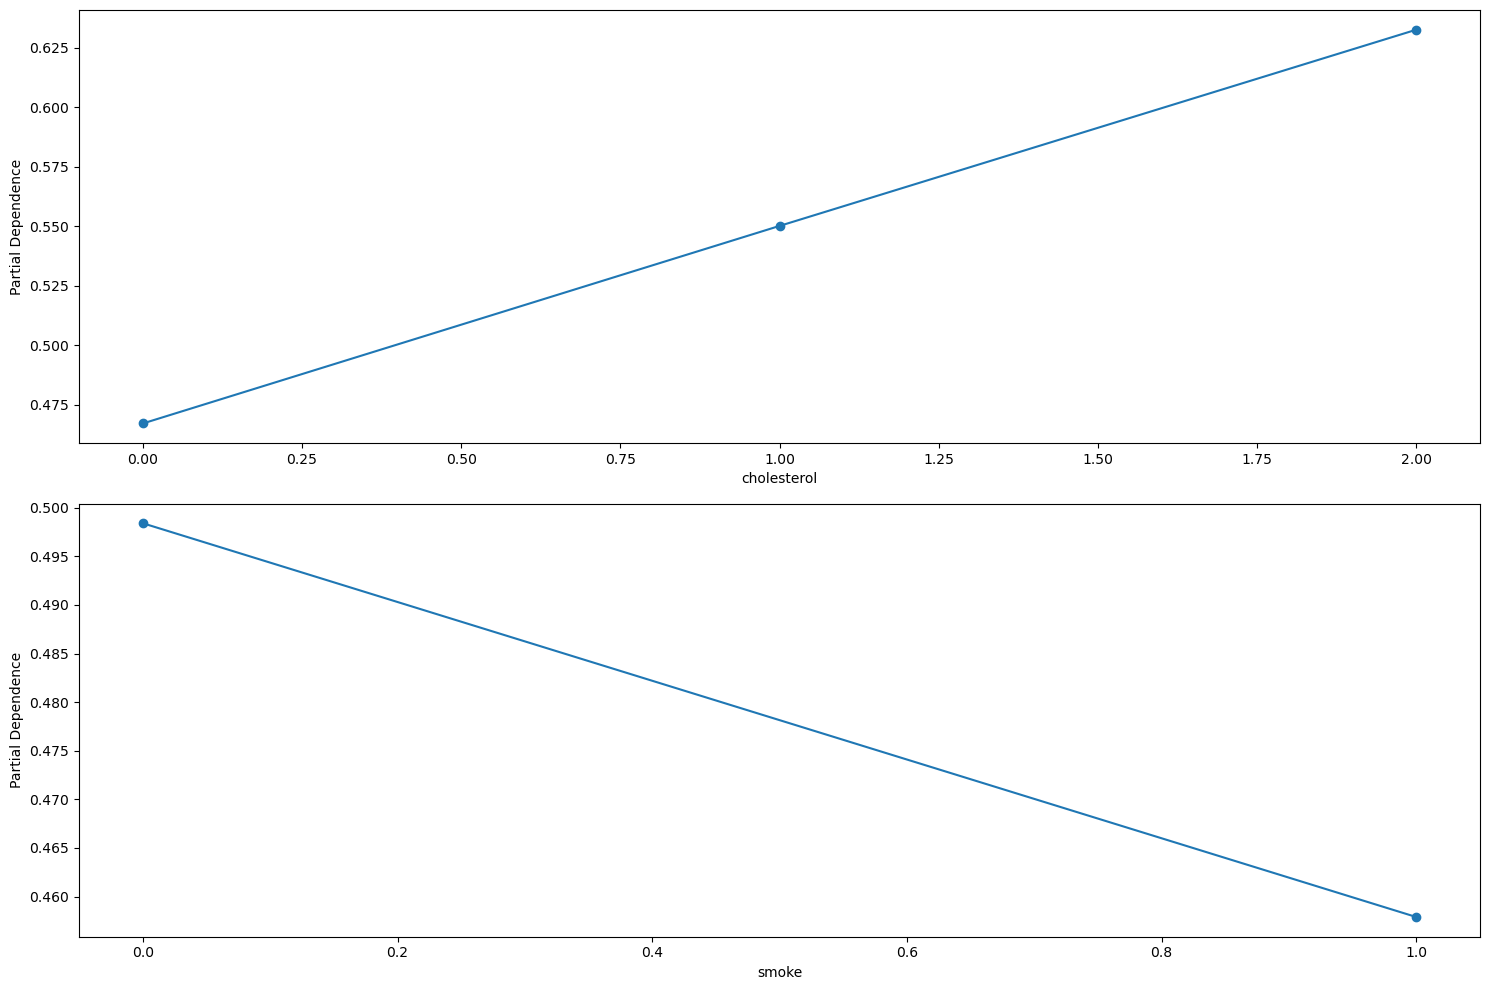

In [12]:
###############################
## LOGISTIC REGRESSION MODEL ##
###############################

# Create a copy of the cleaned dataset to use for logistic regression
df_regression = df.copy()

# Convert all categorical variables to integers
df_regression[categorical] = df_regression[categorical].astype(int)

# Get the dummies
df_with_dummies = pd.get_dummies(df_regression, drop_first=True)

# For logistic regression, statsmodels requires us to add a constant to our model
df_with_dummies['intercept'] = 1.0

# Fit the logistic regression model
model = sm.Logit(df_with_dummies['cardio'], df_with_dummies.drop(columns=['cardio'])).fit()

# Display the model's summary
print(model.summary())

######################################
## NESTED LOGISTIC REGRESSION MODEL ##
######################################

# Drop certain features and fit the model again
df_dropped_stuff = df.copy()
df_dropped_stuff[categorical] = df_dropped_stuff[categorical].astype(int)
df_dropped_stuff = df_dropped_stuff.drop(['gluc', 'alco', 'height', 'ap_lo'], axis=1).copy()
df_dummies = pd.get_dummies(df_dropped_stuff, drop_first=True)
df_dummies['intercept'] = 1.0
model_dropped = sm.Logit(df_dummies['cardio'], df_dummies.drop(columns=['cardio'])).fit()
print(model_dropped.summary())

# Drop 'gender' and fit the model again
df_dropped_stuff_nogend = df.copy()
df_dropped_stuff_nogend[categorical] = df_dropped_stuff_nogend[categorical].astype(int)
df_dropped_stuff_nogend = df_dropped_stuff_nogend.drop(['gluc', 'alco', 'height', 'ap_lo', 'gender'], axis=1).copy()
df_dummies_nogend = pd.get_dummies(df_dropped_stuff_nogend, drop_first=True)
df_dummies_nogend['intercept'] = 1.0
model_dropped_nd = sm.Logit(df_dummies_nogend['cardio'], df_dummies_nogend.drop(columns=['cardio'])).fit()
print(model_dropped_nd.summary())

############################
## COMPARE THE TWO MODELS ##
############################

# Perform the likelihood ratio test
lr_test = model.llf - model_dropped_nd.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof = len(model.params) - len(model_dropped_nd.params)

# p-value
p_value = chi2.sf(lr_test, dof)

print('Likelihood ratio test statistic between the full and cut model:', lr_test)
print('Degrees of freedom:', dof)
print('p-value:', p_value)

# Fit the null model
null_model = sm.Logit(df_with_dummies['cardio'], df_with_dummies['intercept']).fit()
print(null_model.summary())

# Perform the likelihood ratio test
lr_test_null = model_dropped_nd.llf - null_model.llf

# Degrees of freedom of the difference in the number of parameters between the two models
dof_null = len(model_dropped_nd.params) - len(null_model.params)

# p-value
p_value_null = chi2.sf(lr_test_null, dof_null)

print('Likelihood ratio test statistic between the cut and null model:', lr_test_null)
print('Degrees of freedom:', dof_null)
print('p-value:', p_value_null)

#########################################################################################################################################################################

#########################################################################################################################################################################

#########
## GAM ##
#########

# Create a copy of the cleaned dataset to use for logistic regression
df_gam = df.copy()

# Split the data into features and target
X = df_gam.drop('cardio', axis=1)
y = df_gam['cardio']

# Perform a train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Number of splines for each continuous variable, currently not used
n_splines = 5

# Define the model
# Here we're using s() for continuous variables and l() for categorical variables
# The number of splines for each continuous variable can be adjusted using the n_splines parameter; we chose 0
#                 age,      gender,     height,     weight,     ap_hi,      ap_lo,      cholesterol, gluc,      smoke,      alco,       active,     BMI
gam = LogisticGAM(s(0) +    l(1) +      s(2) +      s(3) +      s(4) +      s(5) +      l(6) +      l(7) +      l(8) +      l(9) +      l(10) +     s(11))

# Fit the model
gam.fit(X_train, y_train)

# Predict probabilities and binary outcomes
y_pred_proba = gam.predict_proba(X_test)
y_pred = gam.predict(X_test)

# Convert boolean predictions to integers
y_pred_int = y_pred.astype(int)

# Convert string labels in y_true to integers
y_true_int = y_test.astype(int)

# Calculate AUC and accuracy
auc_score = roc_auc_score(y_true_int, y_pred_proba)
accuracy = accuracy_score(y_true_int, y_pred_int)

print(f'AUC Score: {auc_score}')
print(f'Accuracy: {accuracy}')
gam.summary()

# Plot the estimated functions for each feature
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()
terms = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'BMI']

for i, ax in enumerate(axes):
    term = gam.terms[i + 1]  # Skip the intercept term
    XX = gam.generate_X_grid(term=i + 1)
    pdep, confi = gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label=f'Feature {terms[i]}', color=f'C{i}')  # Use different colors for each feature
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {terms[i]}')
    ax.set_ylabel('Partial Dependence')
    ax.legend()

plt.tight_layout()
plt.show()

# Assuming 'gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active' are categorical variables
categorical_features = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']

# Use LabelEncoder to convert categorical variables to integers
label_encoder = LabelEncoder()
for feature in categorical_features:
    df_gam[feature] = label_encoder.fit_transform(df_gam[feature])

# Create a grid for each unique value in the categorical feature
fig, axes = plt.subplots(len(categorical_features), figsize=(15, 10))

for i, feature in enumerate(categorical_features):
    unique_values = df_gam[feature].unique()
    unique_values.sort()

    # Initialize arrays to store partial dependence values
    pdp_values = np.zeros_like(unique_values, dtype=float)

    for j, value in enumerate(unique_values):
        temp_df = df_gam.copy()
        temp_df[feature] = value

        # Predict using the fitted GAM model
        pdp_values[j] = gam.predict_proba(temp_df.drop('cardio', axis=1)).mean()

    # Plot the partial dependence curve
    axes[i].plot(unique_values, pdp_values, marker='o')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

# Define the model w/7 variables ['gluc', 'alco', 'height', 'ap_lo', 'gender']
# Adjust the terms based on your specific features and needs.
df_gam_dropped_stuff = df_gam.drop(['gluc', 'alco', 'height', 'ap_lo', 'gender'], axis=1).copy()

X_dropped = df_gam_dropped_stuff.drop('cardio', axis=1)
y_dropped = df_gam_dropped_stuff['cardio']

# Define the model
#                          age,               weight,   ap_hi,      cholesterol,    smoke,      active      # BMI
reduced_gam = LogisticGAM(s(0, n_splines=5) + s(1) +    s(2) +      l(3) +          l(4) +      l(5) +      s(6))

# Fit the model
reduced_gam.fit(X_dropped, y_dropped)

# Predict probabilities and binary outcomes
y_pred_proba_dropped = reduced_gam.predict_proba(X_dropped)
y_pred_dropped = reduced_gam.predict(X_dropped)

# Convert boolean predictions to integers
y_pred_int_dropped = y_pred_dropped.astype(int)

# Convert string labels in y_true to integers
y_true_int_dropped = y_dropped.astype(int)

# Calculate AUC and accuracy
auc_score_dropped = roc_auc_score(y_true_int_dropped, y_pred_proba_dropped)
accuracy_dropped = accuracy_score(y_true_int_dropped, y_pred_int_dropped)

print(f'AUC Score: {auc_score_dropped}')
print(f'Accuracy: {accuracy_dropped}')
reduced_gam.summary()

# Plot the estimated functions for each feature
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()
terms_dropped=['age', 'weight', 'ap_hi', 'active', 'BMI']

# Ensure the number of terms matches the length of the 'terms_dropped' list
num_terms_dropped = min(len(terms_dropped), len(reduced_gam.terms) - 1)  # Skip the intercept term
terms_to_plot_dropped = reduced_gam.terms[1:num_terms_dropped + 1]  # Select the relevant terms

for i, ax in enumerate(axes):
    term = terms_to_plot_dropped[i]
    XX = reduced_gam.generate_X_grid(term=i + 1)
    pdep, confi = reduced_gam.partial_dependence(term=i + 1, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label=f'Feature {terms_dropped[i]}', color=f'C{i}')  # Use different colors for each feature
    ax.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], color='gray', alpha=0.3)
    ax.set_xlabel(f'Feature {terms_dropped[i]}')
    ax.set_ylabel('Partial Dependence')
    ax.legend()

plt.tight_layout()
plt.show()

# Assuming 'cholesterol', 'smoke' are categorical variables
categorical_features_dropped = ['cholesterol', 'smoke']

# Use LabelEncoder to convert categorical variables to integers
label_encoder = LabelEncoder()
for feature in categorical_features_dropped:
    df_gam[feature] = label_encoder.fit_transform(df_gam_dropped_stuff[feature])

# Create a grid for each unique value in the categorical feature
fig, axes = plt.subplots(len(categorical_features_dropped), figsize=(15, 10))

for i, feature in enumerate(categorical_features_dropped):
    unique_values = df_gam_dropped_stuff[feature].unique()
    unique_values.sort()

    # Initialize arrays to store partial dependence values
    pdp_values = np.zeros_like(unique_values, dtype=float)

    for j, value in enumerate(unique_values):
        temp_df = df_gam_dropped_stuff.copy()
        temp_df[feature] = value

        # Predict using the fitted GAM model
        pdp_values[j] = reduced_gam.predict_proba(temp_df.drop('cardio', axis=1)).mean()

    # Plot the partial dependence curve
    axes[i].plot(unique_values, pdp_values, marker='o')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Partial Dependence')

plt.tight_layout()
plt.show()

## Decision Tree

Accuracy: 0.7270740767717969
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6878
           1       0.75      0.68      0.71      6851

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.73     13729
weighted avg       0.73      0.73      0.73     13729

{'max_depth': 10, 'min_samples_leaf': 150}
Test score 0.730570325588171
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      6878
           1       0.75      0.68      0.71      6851

    accuracy                           0.73     13729
   macro avg       0.73      0.73      0.73     13729
weighted avg       0.73      0.73      0.73     13729

Test Confusion matrix


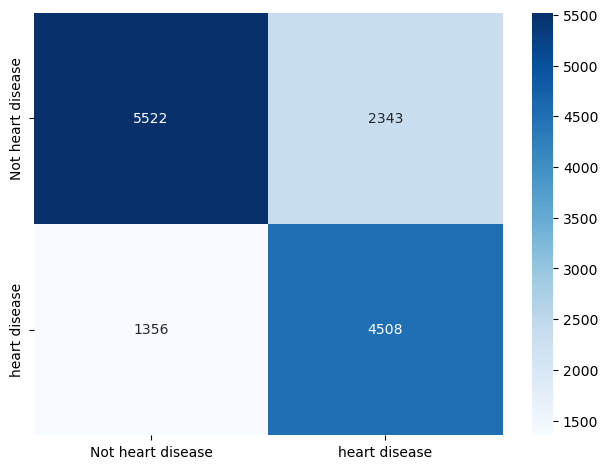

In [8]:
# Create a copy of the cleaned dataset to use for logistic regression
df_tree = df.copy()

# Convert all categorical variables to integers
df_tree[categorical] = df[categorical].astype(int)

# Split the data into X and y
X = df_tree.drop('cardio', axis=1) # Features
y = df_tree['cardio'] # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,)

##############################
## DECISION TREE CLASSIFIER ##
##############################

# Create a decision tree classifier
clf = tree.DecisionTreeClassifier(random_state=42, criterion='gini', splitter='best',max_depth=10, min_samples_leaf= 500)

# Fit the classifier to the training data
clf.fit(X_train,y_train)

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print("Accuracy:", accuracy)

# Print the classification report
print(classification_report(y_test, y_pred))

###################
## PLOT THE TREE ##
###################

# Select the features
df_features = df_tree.drop('cardio', axis=1)

# Get the feature names
features = df_features.columns 

# Classes names
classes = ['Not heart disease','heart disease']

# Plot the tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=features,  
                                class_names=classes,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 
graph.render("decision_tree_graphivz")

#################
## GRID SEARCH ##
#################

# Define the parameters
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_leaf': [i for i in range(100, 500, 50)]}

# Create a decision tree classifier
clf = tree.DecisionTreeClassifier()

# Create a grid search
gcv = GridSearchCV(estimator=clf,param_grid=params)

# Fit the grid search
gcv.fit(X_train,y_train)

# Print the best parameters
print(gcv.best_params_)

# Select the best model
model = gcv.best_estimator_

# Fit the selected classifier to the training data
model.fit(X_train,y_train)

# Predict the labels of the test set
y_test_pred = model.predict(X_test)

# Calculate the accuracy
print(f'Test score {accuracy_score(y_test_pred,y_test)}')

# Print the classification report
print(classification_report(y_test, y_pred))

# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()
    

# Plot the confusion matrix
plot_confusionmatrix(y_test_pred,y_test,dom='Test')


## Random Forest

By Andrea

In [9]:
# Create a copy of the dataset to work on
df_rf = df.copy()

# Initialize the model
model = "rf"

# Initialize the scaler
scaler = "Standard"

# Set the test size
test_size = 0.2

# Set the random state (THE answer)
random_state = 42

# Set the ranges of the hyperparameters
min_samples_split = 2
max_depth = None

# Split the data in features and labels
X_labels = [col for col in df.columns if col != "cardio"]
y_label = "cardio"

# Conve
y = df_rf[y_label].astype(int)
X = df_rf[X_labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

match model:
    case "rf":
        print('Start Random Forest classification')
        classifier = RandomForestClassifier()
        param_grid = dict(clf__min_samples_split = range(2,8),
                            clf__max_depth = range(3,13))
    case "svc":
        print('Start Support Vector classification')
        classifier = SVC(probability=True, cache_size=2000)
        param_grid = dict(clf__gamma = [2**p for p in range(-15,4)], clf__C = [2**p for p in range(-5, 16)])
    case "nb":
        print('Start Naive Bayes classification')
        classifier = BernoulliNB(force_alpha = True)
        param_grid = dict(clf__alpha = np.linspace(1e-10,1.4,50))
    case "knn":
        print('Start k-nearest neighbors classification')
        classifier = KNeighborsClassifier()
        param_grid = dict(clf__n_neighbors = range(3,12,2),
                            clf__weights = ["uniform", "distance"],
                            clf__p = [1,2])
    case "dummy":
        print('Start dummy classification')
        classifier = DummyClassifier()
        param_grid = dict()
    case _:
        raise Exception('Unknown classification model')

# define scaler
match scaler:
    case "MinMax":
        scl = MinMaxScaler()
        print('MinMax scaling done')
    case "Standard":
        scl = StandardScaler()
        print('Standard scaling done')
    case _:
        print('No scaling')

# pipeline glues scaler and classiefier together
pipe = Pipeline([
        ('scale', scl),
        ('clf', classifier)])

# automatic grid seach on afore defined params per classifier
gsc = GridSearchCV(pipe, param_grid = param_grid, scoring='neg_mean_squared_error', n_jobs=-1, refit=True, verbose = 10)

gsc.fit(X_train, y_train) # start actual grid search
y_class = gsc.predict(X_test)
# classifier.fit(X_train, y_train)
# y_class = classifier.predict(X_test)

accuracy = accuracy_score(y_class, y_test)
probs = gsc.predict_proba(X_test)[:, 1]
# probs = classifier.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probs)
pr_auc = auc(recall, precision)
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

if model == "rf":
    # calculate feature importances
    importances = gsc.best_estimator_.named_steps['clf'].feature_importances_
    # importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    print(f"Feature ranking for {model}:")
    for f in range(X_train.shape[1]):
        print(f"{f + 1:>2}. Feature {X_labels[indices[f]]:<17} - importance: {importances[indices[f]]:.6f}")

Start Random Forest classification
Standard scaling done
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV 1/5; 1/60] START clf__max_depth=3, clf__min_samples_split=2.................
[CV 2/5; 1/60] START clf__max_depth=3, clf__min_samples_split=2.................
[CV 3/5; 1/60] START clf__max_depth=3, clf__min_samples_split=2.................
[CV 4/5; 1/60] START clf__max_depth=3, clf__min_samples_split=2.................
[CV 5/5; 1/60] START clf__max_depth=3, clf__min_samples_split=2.................
[CV 1/5; 2/60] START clf__max_depth=3, clf__min_samples_split=3.................
[CV 2/5; 2/60] START clf__max_depth=3, clf__min_samples_split=3.................
[CV 3/5; 2/60] START clf__max_depth=3, clf__min_samples_split=3.................
[CV 4/5; 2/60] START clf__max_depth=3, clf__min_samples_split=3.................
[CV 5/5; 2/60] START clf__max_depth=3, clf__min_samples_split=3.................
[CV 1/5; 3/60] START clf__max_depth=3, clf__min_samples_split=4.................
[CV 2/5; 3/60] START clf__max_depth=3, clf__min_samples_split=4.................
[CV 4/5; 3/60] START clf__ma

## Random Forest Stuff

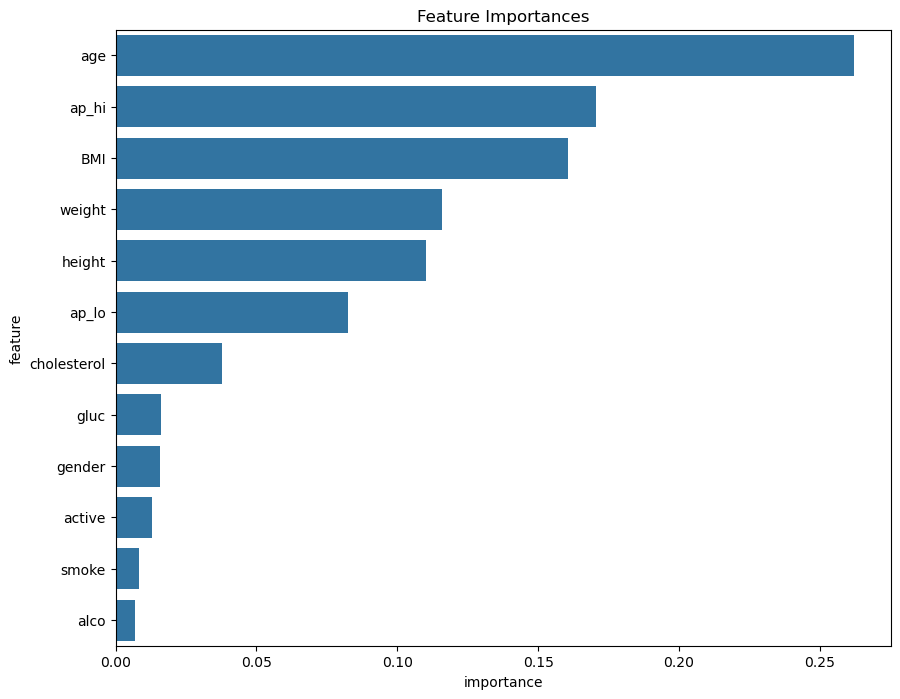

In [10]:
############################################
## FEATURE IMPORTANCE USING RANDOM FOREST ##
############################################

# Create a copy of the cleaned dataset to use for feature importance
df_feature_importance = df.copy()

# Divide the data into features and target
X = df_feature_importance.drop(columns=['cardio']).copy()
y = df_feature_importance['cardio'].copy()

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
rf.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf.feature_importances_

# Create a dataframe with the feature importances
feature_importances_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importances})

# Sort the dataframe by feature importance
feature_importances_df = feature_importances_df.sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importances_df, x='importance', y='feature')
plt.title('Feature Importances')
plt.show()

In [11]:
# ##############################
# ## RANDOM FOREST CLASSIFIER ##
# ##############################

# # Create a copy of the cleaned dataset to use for the random forest classifier
# df_rf = df.copy()

# # Initialize the random forest classifier
# rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# # Split the data into features and target
# X = df_rf.drop(columns=['cardio']).copy()
# y = df_rf['cardio'].copy()

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Create a GridSearchCV object
# param_grid = {
#     'n_estimators': [500],  # Number of trees in the forest
#     'max_depth': [None, 10, 20],  # Maximum depth of the tree for pre-pruning
#     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
#     'max_leaf_nodes': [None, 50, 100],  # Maximum number of leaf nodes
#     'min_impurity_decrease': [0.0, 0.01, 0.1]  # Minimum impurity decrease required for a split to occur
# }
# # Perform the grid search, saving the best hyperparameters and model
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# # Fit the model
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters and model
# best_params = grid_search.best_params_

# # Print the best hyperparameters
# print(best_params)

# # Use the best estimator for predictions
# best_estimator = grid_search.best_estimator_
# y_pred = best_estimator.predict(X_test)

# # Assuming your y_test and y_pred are string type labels
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred, pos_label='1')
# recall = recall_score(y_test, y_pred, pos_label='1')
# f1 = f1_score(y_test, y_pred, pos_label='1')

# # Print the evaluation metrics
# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# print('F1 Score:', f1)

# # Create a confusion matrix
# cm = confusion_matrix(y_test, y_pred)

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()
